# Training Comparisons and Evaluations

##### Authors:
1. Ovidio Manteiga Moar
1. Carlos Villar Martínez

In this notebook the goal is to train a GAN, in this case we will use colour images and a small zdim.

In [48]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
from Data_pre import prepare_data_generator_GAN

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
DATA_FOLDER = "./Dataset/img_align_celeba"

In [50]:
IMAGE_SIZE = 64
CHANNELS = 3

BATCH_SIZE = 16
NUM_FEATURES = 32
Z_DIM = 16

EPOCHS = 1000
STEPS_PER_EPOCH=2

LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

#COLOR_MODE "rgb" or "graysacale"
COLOR_MODE = "rgb"

In [51]:
train = prepare_data_generator_GAN(DATA_FOLDER, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE)

Found 202599 files belonging to 1 classes.


##### Building tthe WGAN-GP

In [52]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_114 (Conv2D)         (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_115 (Conv2D)         (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_116 (Conv2D)         (None, 8, 8, 256)         5245

In [53]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 16)]              0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 1, 16)          0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 4, 4, 512)        131072    
 Transpose)                                                      
                                                                 
 batch_normalization_106 (Ba  (None, 4, 4, 512)        2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 8, 8, 256)        2097

In [54]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        """
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
        """
    
    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}

In [55]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [56]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

##### Training the GAN

In [57]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [58]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


real_images = np.array(list(train.unbatch().take(10).as_numpy_iterator()))
print(real_images.shape)
print(real_images[0].shape)
from fid import get_fid

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.history = { 'fid': [] }

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 != 0:
            return
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)
        #fid = get_fid(real_images, generated_images)
        #self.history['fid'].append(fid)

(10, 64, 64, 3)
(64, 64, 3)


In [59]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

Epoch 1/1000
2/2 [==============================] - ETA: 0s - c_loss: 5.9074 - c_wass_loss: -1.5737 - c_gp: 0.7481 - g_loss: 0.5920 - c_acc: 100.0000 - g_acc: 100.0000 
Saved to ./output/generated_img_000.png


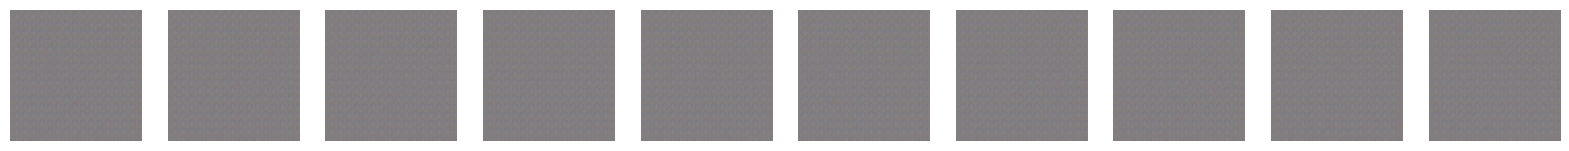

2/2 [==============================] - 17s 4s/step - c_loss: 5.9074 - c_wass_loss: -1.5737 - c_gp: 0.7481 - g_loss: 0.5920 - c_acc: 100.0000 - g_acc: 100.0000
Epoch 2/1000
2/2 [==============================] - 5s 3s/step - c_loss: -27.8460 - c_wass_loss: -30.4008 - c_gp: 0.2555 - g_loss: 7.4948 - c_acc: 100.0000 - g_acc: 100.0000
Epoch 3/1000
2/2 [==============================] - 6s 3s/step - c_loss: -70.5024 - c_wass_loss: -105.6793 - c_gp: 3.5177 - g_loss: 18.9487 - c_acc: 100.0000 - g_acc: 100.0000
Epoch 4/1000
2/2 [==============================] - 5s 3s/step - c_loss: -89.3453 - c_wass_loss: -122.7259 - c_gp: 3.3381 - g_loss: 5.1884 - c_acc: 100.0000 - g_acc: 87.5000
Epoch 5/1000
2/2 [==============================] - 5s 3s/step - c_loss: -101.5927 - c_wass_loss: -150.8757 - c_gp: 4.9283 - g_loss: 1.6113 - c_acc: 100.0000 - g_acc: 64.5833
Epoch 6/1000
2/2 [==============================] - 5s 3s/step - c_loss: -92.0493 - c_wass_loss: -135.6908 - c_gp: 4.3642 - g_loss: 35.3090 - 

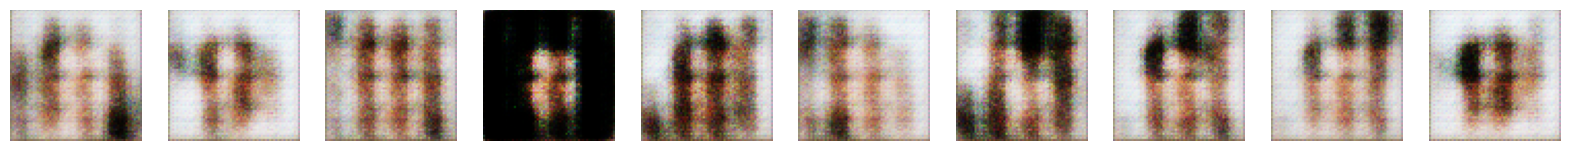

2/2 [==============================] - 6s 3s/step - c_loss: -16.6448 - c_wass_loss: -18.1041 - c_gp: 0.1459 - g_loss: 28.2582 - c_acc: 14.5833 - g_acc: 100.0000
Epoch 52/1000
2/2 [==============================] - 5s 3s/step - c_loss: -11.3656 - c_wass_loss: -14.8746 - c_gp: 0.3509 - g_loss: 2.1843 - c_acc: 66.6667 - g_acc: 45.8333
Epoch 53/1000
2/2 [==============================] - 5s 3s/step - c_loss: -14.8350 - c_wass_loss: -17.8006 - c_gp: 0.2966 - g_loss: 11.9488 - c_acc: 72.9167 - g_acc: 97.9167
Epoch 54/1000
2/2 [==============================] - 5s 3s/step - c_loss: -12.8797 - c_wass_loss: -15.9900 - c_gp: 0.3110 - g_loss: -0.9899 - c_acc: 83.3333 - g_acc: 35.4167
Epoch 55/1000
2/2 [==============================] - 5s 3s/step - c_loss: -3.0831 - c_wass_loss: -4.6392 - c_gp: 0.1556 - g_loss: -23.2958 - c_acc: 89.5833 - g_acc: 6.2500
Epoch 56/1000
2/2 [==============================] - 5s 3s/step - c_loss: -14.7455 - c_wass_loss: -17.1064 - c_gp: 0.2361 - g_loss: -17.8481 - c_a

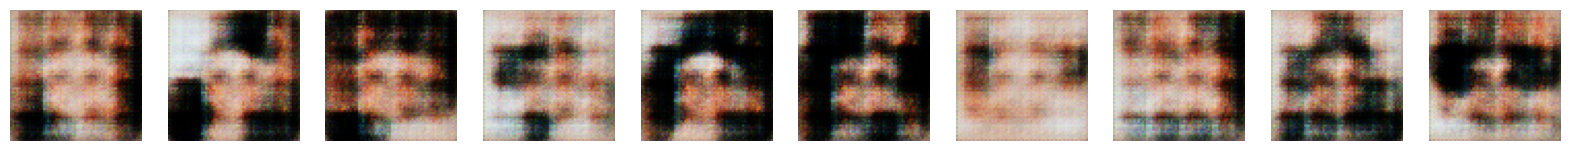

2/2 [==============================] - 6s 3s/step - c_loss: -9.7372 - c_wass_loss: -10.6439 - c_gp: 0.0907 - g_loss: -4.0295 - c_acc: 91.6667 - g_acc: 37.5000
Epoch 102/1000
2/2 [==============================] - 5s 3s/step - c_loss: -12.3341 - c_wass_loss: -13.9834 - c_gp: 0.1649 - g_loss: -13.3950 - c_acc: 100.0000 - g_acc: 6.2500
Epoch 103/1000
2/2 [==============================] - 5s 3s/step - c_loss: -19.7741 - c_wass_loss: -22.6864 - c_gp: 0.2912 - g_loss: -22.5384 - c_acc: 100.0000 - g_acc: 2.0833
Epoch 104/1000
2/2 [==============================] - 5s 3s/step - c_loss: -11.9159 - c_wass_loss: -15.7602 - c_gp: 0.3844 - g_loss: -48.1361 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 105/1000
2/2 [==============================] - 5s 3s/step - c_loss: -5.9532 - c_wass_loss: -7.1101 - c_gp: 0.1157 - g_loss: -46.7810 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 106/1000
2/2 [==============================] - 5s 3s/step - c_loss: -4.8765 - c_wass_loss: -5.4437 - c_gp: 0.0567 - g_loss: 

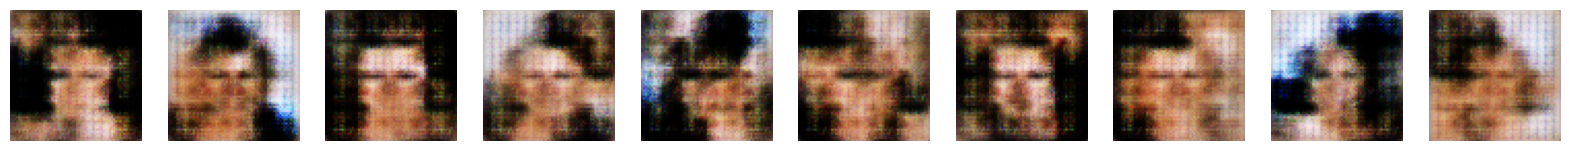

2/2 [==============================] - 7s 4s/step - c_loss: -8.4757 - c_wass_loss: -9.9181 - c_gp: 0.1442 - g_loss: -22.3408 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 152/1000
2/2 [==============================] - 5s 3s/step - c_loss: -6.7497 - c_wass_loss: -8.2859 - c_gp: 0.1536 - g_loss: -50.8144 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 153/1000
2/2 [==============================] - 5s 3s/step - c_loss: -12.7601 - c_wass_loss: -15.3102 - c_gp: 0.2550 - g_loss: -67.3244 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 154/1000
2/2 [==============================] - 5s 3s/step - c_loss: -8.6918 - c_wass_loss: -10.3217 - c_gp: 0.1630 - g_loss: -62.3961 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 155/1000
2/2 [==============================] - 5s 3s/step - c_loss: -10.5783 - c_wass_loss: -11.4033 - c_gp: 0.0825 - g_loss: -49.5075 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 156/1000
2/2 [==============================] - 5s 3s/step - c_loss: -6.8714 - c_wass_loss: -7.7376 - c_gp: 0.0866

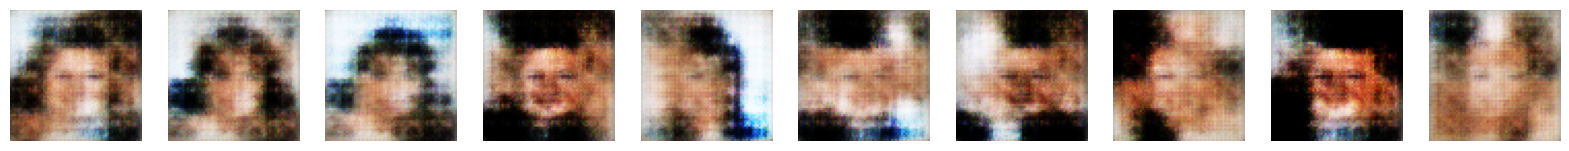

2/2 [==============================] - 6s 4s/step - c_loss: -5.2591 - c_wass_loss: -6.0045 - c_gp: 0.0745 - g_loss: -1.4246 - c_acc: 70.8333 - g_acc: 43.7500
Epoch 202/1000
2/2 [==============================] - 6s 3s/step - c_loss: -2.3176 - c_wass_loss: -2.9745 - c_gp: 0.0657 - g_loss: -17.6456 - c_acc: 93.7500 - g_acc: 4.1667
Epoch 203/1000
2/2 [==============================] - 5s 3s/step - c_loss: -3.2306 - c_wass_loss: -3.6984 - c_gp: 0.0468 - g_loss: -36.2600 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 204/1000
2/2 [==============================] - 5s 3s/step - c_loss: -6.9824 - c_wass_loss: -7.9114 - c_gp: 0.0929 - g_loss: -40.9037 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 205/1000
2/2 [==============================] - 5s 3s/step - c_loss: -14.9040 - c_wass_loss: -18.1552 - c_gp: 0.3251 - g_loss: -25.6312 - c_acc: 91.6667 - g_acc: 20.8333
Epoch 206/1000
2/2 [==============================] - 5s 3s/step - c_loss: -3.7988 - c_wass_loss: -4.6464 - c_gp: 0.0848 - g_loss: 4.2170

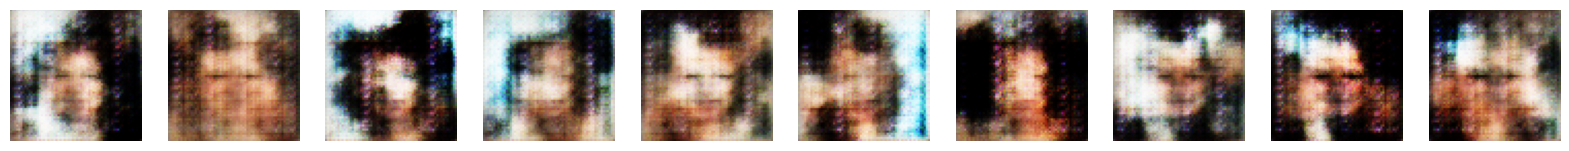

2/2 [==============================] - 6s 4s/step - c_loss: -5.8123 - c_wass_loss: -6.2402 - c_gp: 0.0428 - g_loss: -21.6430 - c_acc: 97.9167 - g_acc: 12.5000
Epoch 252/1000
2/2 [==============================] - 5s 3s/step - c_loss: -2.8419 - c_wass_loss: -3.2459 - c_gp: 0.0404 - g_loss: -22.6118 - c_acc: 79.1667 - g_acc: 18.7500
Epoch 253/1000
2/2 [==============================] - 5s 3s/step - c_loss: -9.0349 - c_wass_loss: -9.3942 - c_gp: 0.0359 - g_loss: -12.4732 - c_acc: 87.5000 - g_acc: 25.0000
Epoch 254/1000
2/2 [==============================] - 5s 3s/step - c_loss: -1.0133 - c_wass_loss: -1.4222 - c_gp: 0.0409 - g_loss: -8.7450 - c_acc: 77.0833 - g_acc: 29.1667
Epoch 255/1000
2/2 [==============================] - 5s 3s/step - c_loss: 2.4824 - c_wass_loss: 2.0483 - c_gp: 0.0434 - g_loss: -17.0968 - c_acc: 83.3333 - g_acc: 16.6667
Epoch 256/1000
2/2 [==============================] - 5s 3s/step - c_loss: -11.8622 - c_wass_loss: -12.4274 - c_gp: 0.0565 - g_loss: -26.7803 - c_ac

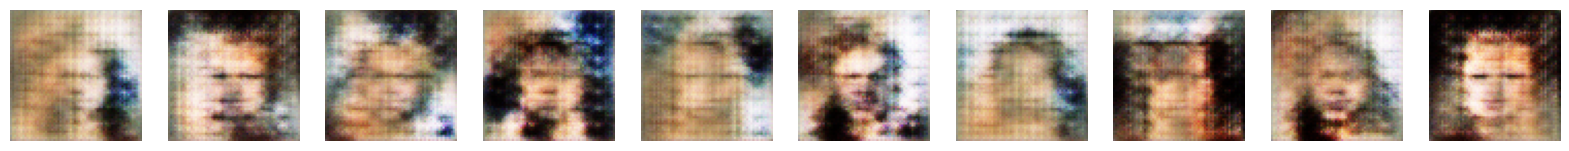

2/2 [==============================] - 7s 4s/step - c_loss: -2.4052 - c_wass_loss: -3.1879 - c_gp: 0.0783 - g_loss: -15.9616 - c_acc: 100.0000 - g_acc: 14.5833
Epoch 302/1000
2/2 [==============================] - 6s 3s/step - c_loss: -3.6003 - c_wass_loss: -4.1451 - c_gp: 0.0545 - g_loss: -10.9520 - c_acc: 75.0000 - g_acc: 20.8333
Epoch 303/1000
2/2 [==============================] - 6s 3s/step - c_loss: -5.2920 - c_wass_loss: -5.6375 - c_gp: 0.0346 - g_loss: 12.4843 - c_acc: 58.3333 - g_acc: 75.0000
Epoch 304/1000
2/2 [==============================] - 7s 4s/step - c_loss: -13.8541 - c_wass_loss: -14.4399 - c_gp: 0.0586 - g_loss: 35.2783 - c_acc: 16.6667 - g_acc: 95.8333
Epoch 305/1000
2/2 [==============================] - 11s 4s/step - c_loss: -7.8017 - c_wass_loss: -8.9683 - c_gp: 0.1167 - g_loss: 41.2293 - c_acc: 0.0000e+00 - g_acc: 100.0000
Epoch 306/1000
2/2 [==============================] - 5s 3s/step - c_loss: -6.7488 - c_wass_loss: -7.3610 - c_gp: 0.0612 - g_loss: 38.0154 -

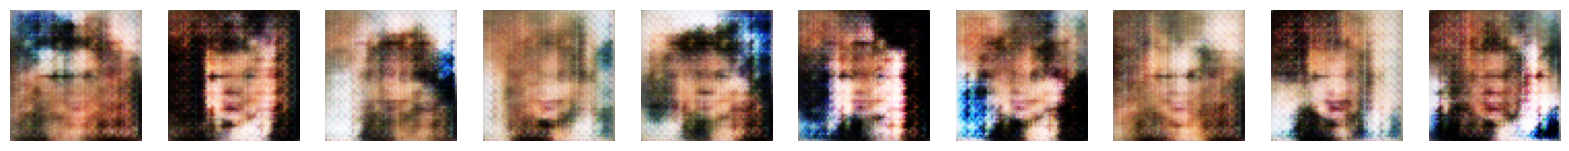

2/2 [==============================] - 13s 8s/step - c_loss: -2.1952 - c_wass_loss: -2.8104 - c_gp: 0.0615 - g_loss: -26.7655 - c_acc: 87.5000 - g_acc: 4.1667
Epoch 352/1000
2/2 [==============================] - 8s 4s/step - c_loss: -2.2715 - c_wass_loss: -2.7008 - c_gp: 0.0429 - g_loss: -21.3722 - c_acc: 91.6667 - g_acc: 6.2500
Epoch 353/1000
2/2 [==============================] - 7s 4s/step - c_loss: -5.9735 - c_wass_loss: -6.3970 - c_gp: 0.0423 - g_loss: -26.3336 - c_acc: 93.7500 - g_acc: 4.1667
Epoch 354/1000
2/2 [==============================] - 6s 3s/step - c_loss: -14.5171 - c_wass_loss: -14.7513 - c_gp: 0.0234 - g_loss: -25.5730 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 355/1000
2/2 [==============================] - 5s 3s/step - c_loss: -17.4685 - c_wass_loss: -21.6072 - c_gp: 0.4139 - g_loss: -48.2546 - c_acc: 87.5000 - g_acc: 4.1667
Epoch 356/1000
2/2 [==============================] - 6s 4s/step - c_loss: -8.5822 - c_wass_loss: -13.3931 - c_gp: 0.4811 - g_loss: -59.9674

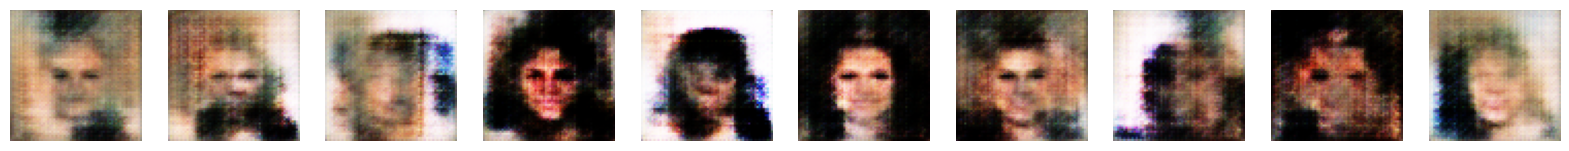

2/2 [==============================] - 6s 4s/step - c_loss: -6.2340 - c_wass_loss: -6.3978 - c_gp: 0.0164 - g_loss: -43.2878 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 402/1000
2/2 [==============================] - 6s 3s/step - c_loss: -12.9259 - c_wass_loss: -14.1395 - c_gp: 0.1214 - g_loss: -48.6639 - c_acc: 100.0000 - g_acc: 8.3333
Epoch 403/1000
2/2 [==============================] - 5s 3s/step - c_loss: -20.7748 - c_wass_loss: -25.4781 - c_gp: 0.4703 - g_loss: -65.7189 - c_acc: 100.0000 - g_acc: 4.1667
Epoch 404/1000
2/2 [==============================] - 5s 3s/step - c_loss: -6.4836 - c_wass_loss: -8.7793 - c_gp: 0.2296 - g_loss: -15.6532 - c_acc: 87.5000 - g_acc: 39.5833
Epoch 405/1000
2/2 [==============================] - 5s 3s/step - c_loss: -3.6210 - c_wass_loss: -4.1512 - c_gp: 0.0530 - g_loss: -28.2616 - c_acc: 87.5000 - g_acc: 25.0000
Epoch 406/1000
2/2 [==============================] - 5s 3s/step - c_loss: -4.6283 - c_wass_loss: -4.7468 - c_gp: 0.0118 - g_loss: -37.09

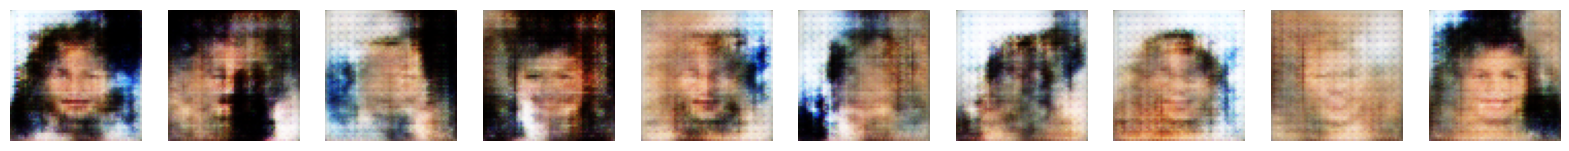

2/2 [==============================] - 6s 4s/step - c_loss: -14.8253 - c_wass_loss: -16.7640 - c_gp: 0.1939 - g_loss: -43.7424 - c_acc: 81.2500 - g_acc: 20.8333
Epoch 452/1000
2/2 [==============================] - 6s 3s/step - c_loss: -7.8365 - c_wass_loss: -9.2245 - c_gp: 0.1388 - g_loss: -26.3809 - c_acc: 81.2500 - g_acc: 31.2500
Epoch 453/1000
2/2 [==============================] - 5s 3s/step - c_loss: -5.2562 - c_wass_loss: -6.7141 - c_gp: 0.1458 - g_loss: -55.8860 - c_acc: 81.2500 - g_acc: 8.3333
Epoch 454/1000
2/2 [==============================] - 6s 3s/step - c_loss: 6.4242 - c_wass_loss: 5.5991 - c_gp: 0.0825 - g_loss: -76.2408 - c_acc: 91.6667 - g_acc: 4.1667  
Epoch 455/1000
2/2 [==============================] - 7s 4s/step - c_loss: -27.9373 - c_wass_loss: -28.6648 - c_gp: 0.0728 - g_loss: -57.8345 - c_acc: 91.6667 - g_acc: 14.5833
Epoch 456/1000
2/2 [==============================] - 7s 3s/step - c_loss: -22.4968 - c_wass_loss: -23.5099 - c_gp: 0.1013 - g_loss: -84.7408 -

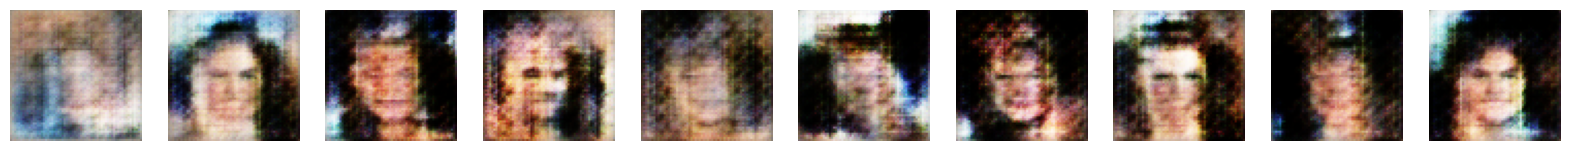

2/2 [==============================] - 6s 4s/step - c_loss: -11.4373 - c_wass_loss: -11.9416 - c_gp: 0.0504 - g_loss: -72.1570 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 502/1000
2/2 [==============================] - 5s 3s/step - c_loss: 4.5365 - c_wass_loss: 4.1920 - c_gp: 0.0344 - g_loss: -68.0942 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 503/1000
2/2 [==============================] - 7s 4s/step - c_loss: -12.8400 - c_wass_loss: -13.2066 - c_gp: 0.0367 - g_loss: -44.4683 - c_acc: 100.0000 - g_acc: 12.5000
Epoch 504/1000
2/2 [==============================] - 6s 3s/step - c_loss: -9.8259 - c_wass_loss: -10.2256 - c_gp: 0.0400 - g_loss: -52.5975 - c_acc: 95.8333 - g_acc: 2.0833
Epoch 505/1000
2/2 [==============================] - 6s 3s/step - c_loss: -25.3643 - c_wass_loss: -26.3807 - c_gp: 0.1016 - g_loss: -103.0354 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 506/1000
2/2 [==============================] - 5s 3s/step - c_loss: -7.3031 - c_wass_loss: -8.6801 - c_gp: 0.1377 - g_lo

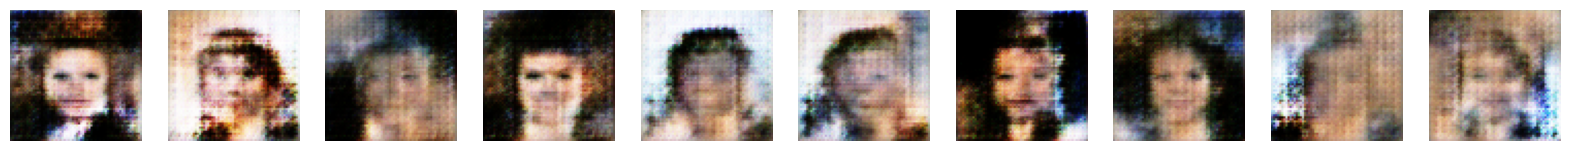

2/2 [==============================] - 6s 4s/step - c_loss: 4.9591 - c_wass_loss: 4.8269 - c_gp: 0.0132 - g_loss: 19.6701 - c_acc: 2.0833 - g_acc: 77.0833
Epoch 552/1000
2/2 [==============================] - 5s 3s/step - c_loss: 7.5674 - c_wass_loss: 7.4607 - c_gp: 0.0107 - g_loss: 17.0926 - c_acc: 27.0833 - g_acc: 68.7500
Epoch 553/1000
2/2 [==============================] - 5s 3s/step - c_loss: -5.5825 - c_wass_loss: -5.7420 - c_gp: 0.0159 - g_loss: 12.1988 - c_acc: 27.0833 - g_acc: 70.8333
Epoch 554/1000
2/2 [==============================] - 5s 3s/step - c_loss: -9.4249 - c_wass_loss: -9.4955 - c_gp: 0.0071 - g_loss: 5.6163 - c_acc: 58.3333 - g_acc: 52.0833
Epoch 555/1000
2/2 [==============================] - 5s 3s/step - c_loss: -18.2013 - c_wass_loss: -18.6299 - c_gp: 0.0429 - g_loss: -8.8941 - c_acc: 83.3333 - g_acc: 41.6667
Epoch 556/1000
2/2 [==============================] - 5s 3s/step - c_loss: -13.2437 - c_wass_loss: -14.9809 - c_gp: 0.1737 - g_loss: -18.7053 - c_acc: 77.

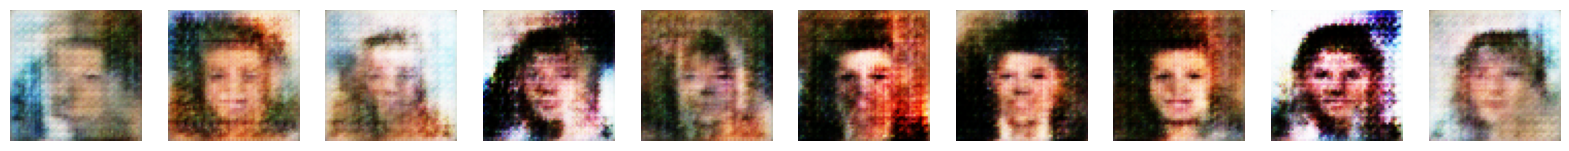

2/2 [==============================] - 8s 6s/step - c_loss: 3.0594 - c_wass_loss: 2.8031 - c_gp: 0.0256 - g_loss: -58.0265 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 602/1000
2/2 [==============================] - 6s 3s/step - c_loss: 0.5670 - c_wass_loss: 0.2586 - c_gp: 0.0308 - g_loss: -49.1408 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 603/1000
2/2 [==============================] - 5s 3s/step - c_loss: -7.2553 - c_wass_loss: -7.6043 - c_gp: 0.0349 - g_loss: -31.6942 - c_acc: 91.6667 - g_acc: 12.5000
Epoch 604/1000
2/2 [==============================] - 5s 3s/step - c_loss: -7.7243 - c_wass_loss: -8.7210 - c_gp: 0.0997 - g_loss: -18.6503 - c_acc: 77.0833 - g_acc: 29.1667
Epoch 605/1000
2/2 [==============================] - 5s 3s/step - c_loss: -4.8507 - c_wass_loss: -5.2622 - c_gp: 0.0411 - g_loss: -10.9031 - c_acc: 83.3333 - g_acc: 41.6667
Epoch 606/1000
2/2 [==============================] - 5s 3s/step - c_loss: -2.3054 - c_wass_loss: -2.5308 - c_gp: 0.0225 - g_loss: 9.4573 - c

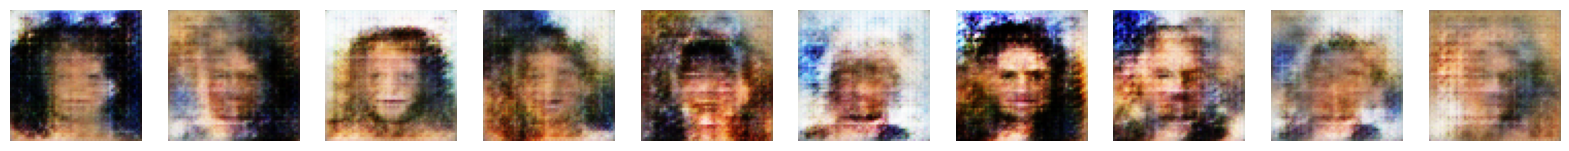

2/2 [==============================] - 6s 4s/step - c_loss: -14.4959 - c_wass_loss: -14.8545 - c_gp: 0.0359 - g_loss: -58.3348 - c_acc: 100.0000 - g_acc: 4.1667
Epoch 652/1000
2/2 [==============================] - 5s 3s/step - c_loss: -14.1383 - c_wass_loss: -14.5338 - c_gp: 0.0396 - g_loss: -54.2857 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 653/1000
2/2 [==============================] - 5s 3s/step - c_loss: 5.4889 - c_wass_loss: 4.9396 - c_gp: 0.0549 - g_loss: -59.6047 - c_acc: 100.0000 - g_acc: 4.1667
Epoch 654/1000
2/2 [==============================] - 5s 3s/step - c_loss: -6.5753 - c_wass_loss: -6.7864 - c_gp: 0.0211 - g_loss: -40.7144 - c_acc: 100.0000 - g_acc: 4.1667  
Epoch 655/1000
2/2 [==============================] - 5s 3s/step - c_loss: -9.9059 - c_wass_loss: -10.4846 - c_gp: 0.0579 - g_loss: -31.5148 - c_acc: 91.6667 - g_acc: 8.3333  
Epoch 656/1000
2/2 [==============================] - 5s 3s/step - c_loss: -4.3236 - c_wass_loss: -5.3875 - c_gp: 0.1064 - g_loss: -19.

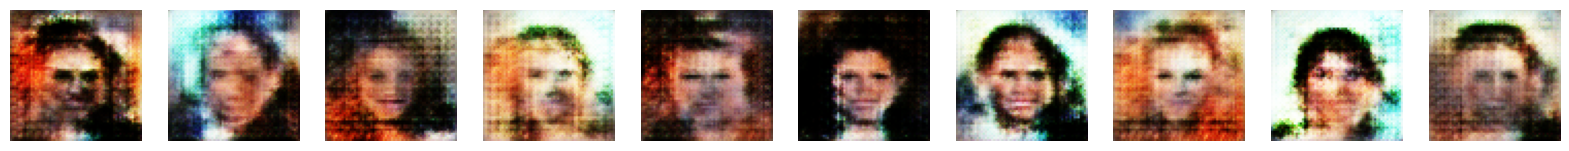

2/2 [==============================] - 6s 3s/step - c_loss: -6.3783 - c_wass_loss: -9.1900 - c_gp: 0.2812 - g_loss: -86.1251 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 702/1000
2/2 [==============================] - 5s 3s/step - c_loss: 4.5564 - c_wass_loss: 3.5290 - c_gp: 0.1027 - g_loss: -65.0863 - c_acc: 100.0000 - g_acc: 2.0833
Epoch 703/1000
2/2 [==============================] - 5s 3s/step - c_loss: 0.7245 - c_wass_loss: -0.4896 - c_gp: 0.1214 - g_loss: -42.3252 - c_acc: 100.0000 - g_acc: 10.4167
Epoch 704/1000
2/2 [==============================] - 5s 3s/step - c_loss: -4.6200 - c_wass_loss: -5.3244 - c_gp: 0.0704 - g_loss: -46.1987 - c_acc: 100.0000 - g_acc: 4.1667
Epoch 705/1000
2/2 [==============================] - 5s 3s/step - c_loss: -5.6841 - c_wass_loss: -5.8026 - c_gp: 0.0119 - g_loss: -44.0027 - c_acc: 95.8333 - g_acc: 10.4167
Epoch 706/1000
2/2 [==============================] - 5s 3s/step - c_loss: -14.0501 - c_wass_loss: -14.6027 - c_gp: 0.0553 - g_loss: -47.1180 -

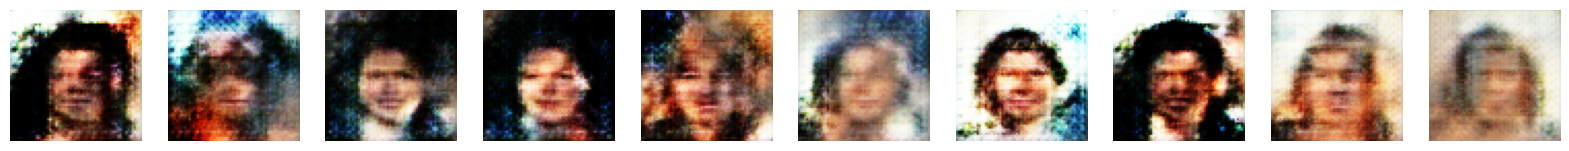

2/2 [==============================] - 6s 4s/step - c_loss: -15.8009 - c_wass_loss: -16.3417 - c_gp: 0.0541 - g_loss: -78.0926 - c_acc: 100.0000 - g_acc: 4.1667
Epoch 752/1000
2/2 [==============================] - 6s 3s/step - c_loss: -23.0176 - c_wass_loss: -25.9790 - c_gp: 0.2961 - g_loss: -147.4511 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 753/1000
2/2 [==============================] - 6s 3s/step - c_loss: -13.8882 - c_wass_loss: -15.3307 - c_gp: 0.1443 - g_loss: -113.5503 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 754/1000
2/2 [==============================] - 6s 3s/step - c_loss: 8.8717 - c_wass_loss: 7.8567 - c_gp: 0.1015 - g_loss: -116.3224 - c_acc: 95.8333 - g_acc: 0.0000e+00 
Epoch 755/1000
2/2 [==============================] - 5s 3s/step - c_loss: 3.2594 - c_wass_loss: 2.2160 - c_gp: 0.1043 - g_loss: -76.3380 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 756/1000
2/2 [==============================] - 5s 3s/step - c_loss: -29.1146 - c_wass_loss: -33.6248 - c_gp: 0.4510 -

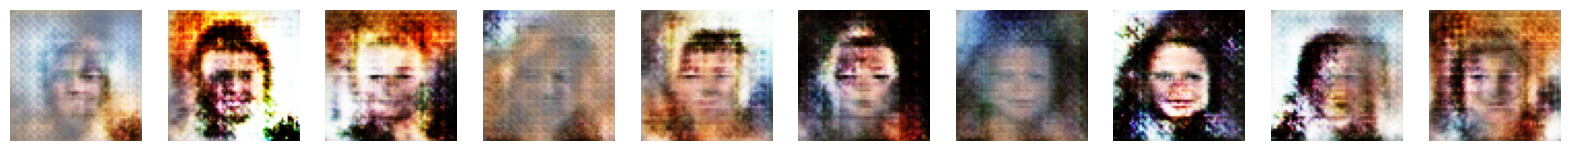

2/2 [==============================] - 7s 4s/step - c_loss: -14.6593 - c_wass_loss: -14.8825 - c_gp: 0.0223 - g_loss: -34.1135 - c_acc: 81.2500 - g_acc: 16.6667
Epoch 802/1000
2/2 [==============================] - 7s 4s/step - c_loss: -12.8309 - c_wass_loss: -13.3447 - c_gp: 0.0514 - g_loss: -12.3914 - c_acc: 68.7500 - g_acc: 33.3333
Epoch 803/1000
2/2 [==============================] - 7s 3s/step - c_loss: 10.1474 - c_wass_loss: 9.7616 - c_gp: 0.0386 - g_loss: 3.1581 - c_acc: 47.9167 - g_acc: 54.1667
Epoch 804/1000
2/2 [==============================] - 6s 3s/step - c_loss: -9.3298 - c_wass_loss: -9.5686 - c_gp: 0.0239 - g_loss: 15.7286 - c_acc: 45.8333 - g_acc: 72.9167
Epoch 805/1000
2/2 [==============================] - 5s 3s/step - c_loss: -18.5450 - c_wass_loss: -19.4850 - c_gp: 0.0940 - g_loss: 4.4414 - c_acc: 66.6667 - g_acc: 54.1667
Epoch 806/1000
2/2 [==============================] - 5s 3s/step - c_loss: -6.2493 - c_wass_loss: -7.0308 - c_gp: 0.0782 - g_loss: 22.5674 - c_ac

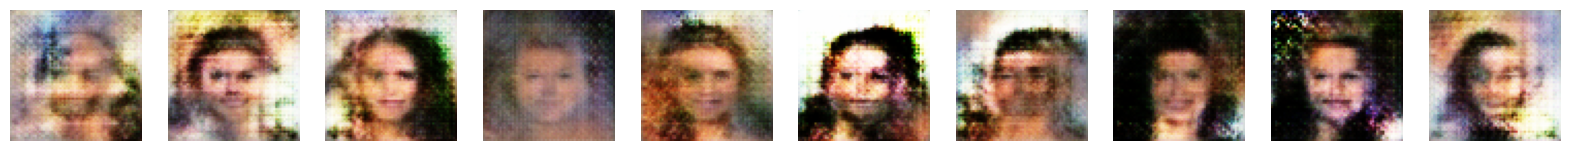

2/2 [==============================] - 6s 4s/step - c_loss: 5.8033 - c_wass_loss: 5.6831 - c_gp: 0.0120 - g_loss: 17.4251 - c_acc: 29.1667 - g_acc: 70.8333
Epoch 852/1000
2/2 [==============================] - 6s 3s/step - c_loss: 2.9790 - c_wass_loss: 2.8959 - c_gp: 0.0083 - g_loss: 12.0470 - c_acc: 35.4167 - g_acc: 58.3333
Epoch 853/1000
2/2 [==============================] - 5s 3s/step - c_loss: -8.9651 - c_wass_loss: -9.3005 - c_gp: 0.0335 - g_loss: 3.3038 - c_acc: 50.0000 - g_acc: 56.2500
Epoch 854/1000
2/2 [==============================] - 5s 3s/step - c_loss: 23.8542 - c_wass_loss: 23.5730 - c_gp: 0.0281 - g_loss: -14.6416 - c_acc: 35.4167 - g_acc: 43.7500
Epoch 855/1000
2/2 [==============================] - 5s 3s/step - c_loss: 1.3035 - c_wass_loss: 1.1744 - c_gp: 0.0129 - g_loss: 1.3002 - c_acc: 39.5833 - g_acc: 52.0833
Epoch 856/1000
2/2 [==============================] - 7s 3s/step - c_loss: 1.3146 - c_wass_loss: 1.1690 - c_gp: 0.0146 - g_loss: 28.7189 - c_acc: 20.8333 - g

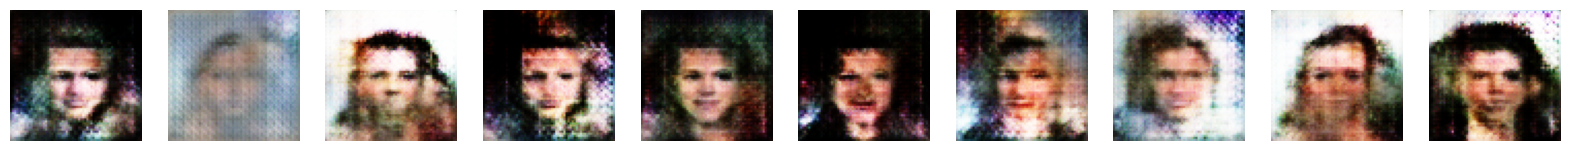

2/2 [==============================] - 6s 4s/step - c_loss: -17.3860 - c_wass_loss: -17.7101 - c_gp: 0.0324 - g_loss: -73.1141 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 902/1000
2/2 [==============================] - 5s 3s/step - c_loss: -8.2514 - c_wass_loss: -8.6075 - c_gp: 0.0356 - g_loss: -46.9540 - c_acc: 95.8333 - g_acc: 6.2500
Epoch 903/1000
2/2 [==============================] - 5s 3s/step - c_loss: 3.1547 - c_wass_loss: 2.8630 - c_gp: 0.0292 - g_loss: -42.6355 - c_acc: 91.6667 - g_acc: 8.3333
Epoch 904/1000
2/2 [==============================] - 6s 3s/step - c_loss: -20.7756 - c_wass_loss: -21.4111 - c_gp: 0.0635 - g_loss: -81.2974 - c_acc: 97.9167 - g_acc: 2.0833
Epoch 905/1000
2/2 [==============================] - 5s 3s/step - c_loss: -13.3128 - c_wass_loss: -15.4100 - c_gp: 0.2097 - g_loss: -108.0440 - c_acc: 95.8333 - g_acc: 0.0000e+00
Epoch 906/1000
2/2 [==============================] - 5s 3s/step - c_loss: 7.0147 - c_wass_loss: 6.2990 - c_gp: 0.0716 - g_loss: -74.447

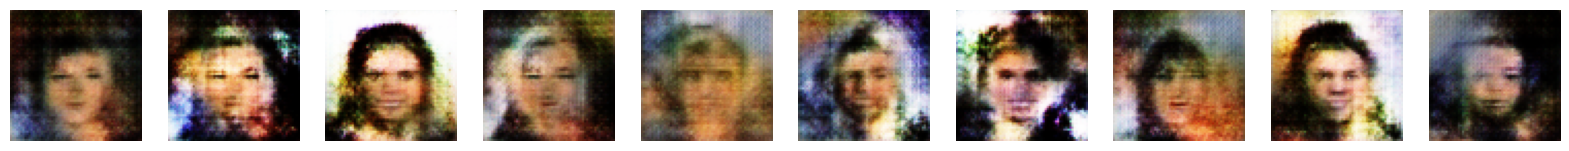

2/2 [==============================] - 6s 4s/step - c_loss: -2.2241 - c_wass_loss: -5.5898 - c_gp: 0.3366 - g_loss: 43.8250 - c_acc: 18.7500 - g_acc: 72.9167
Epoch 952/1000
2/2 [==============================] - 5s 3s/step - c_loss: 5.3732 - c_wass_loss: 3.2387 - c_gp: 0.2135 - g_loss: 29.8734 - c_acc: 22.9167 - g_acc: 68.7500
Epoch 953/1000
2/2 [==============================] - 5s 3s/step - c_loss: -12.0128 - c_wass_loss: -12.4131 - c_gp: 0.0400 - g_loss: 36.3103 - c_acc: 39.5833 - g_acc: 81.2500
Epoch 954/1000
2/2 [==============================] - 5s 3s/step - c_loss: -4.9891 - c_wass_loss: -5.3266 - c_gp: 0.0338 - g_loss: 13.2055 - c_acc: 31.2500 - g_acc: 68.7500
Epoch 955/1000
2/2 [==============================] - 5s 3s/step - c_loss: 11.6256 - c_wass_loss: 11.4209 - c_gp: 0.0205 - g_loss: 35.6198 - c_acc: 16.6667 - g_acc: 83.3333
Epoch 956/1000
2/2 [==============================] - 5s 3s/step - c_loss: -5.1624 - c_wass_loss: -5.8829 - c_gp: 0.0721 - g_loss: 47.5688 - c_acc: 18

In [60]:
loss_history = LossHistory()

wgangp.fit(
    train,
    #train.take(1),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    #steps_per_epoch=1,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM), loss_history],
)

In [61]:
# Save the model to explore latent space
# It doesn't work with subclassed models.

# tf.saved_model.save(wgangp, "models/wgangp")


##### Generate the images

1/1 [==============================] - 0s 352ms/step


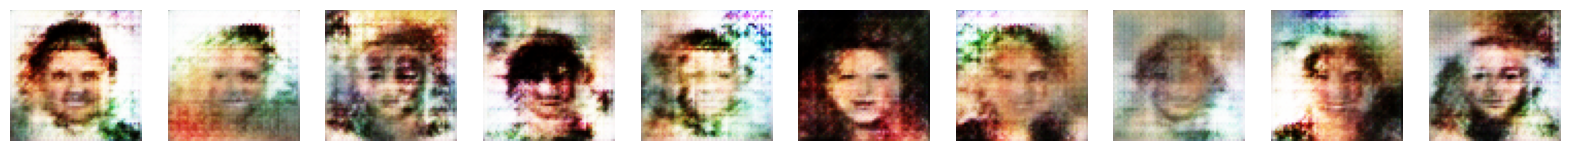

In [62]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

Again the faces are pretty far from a real face. 

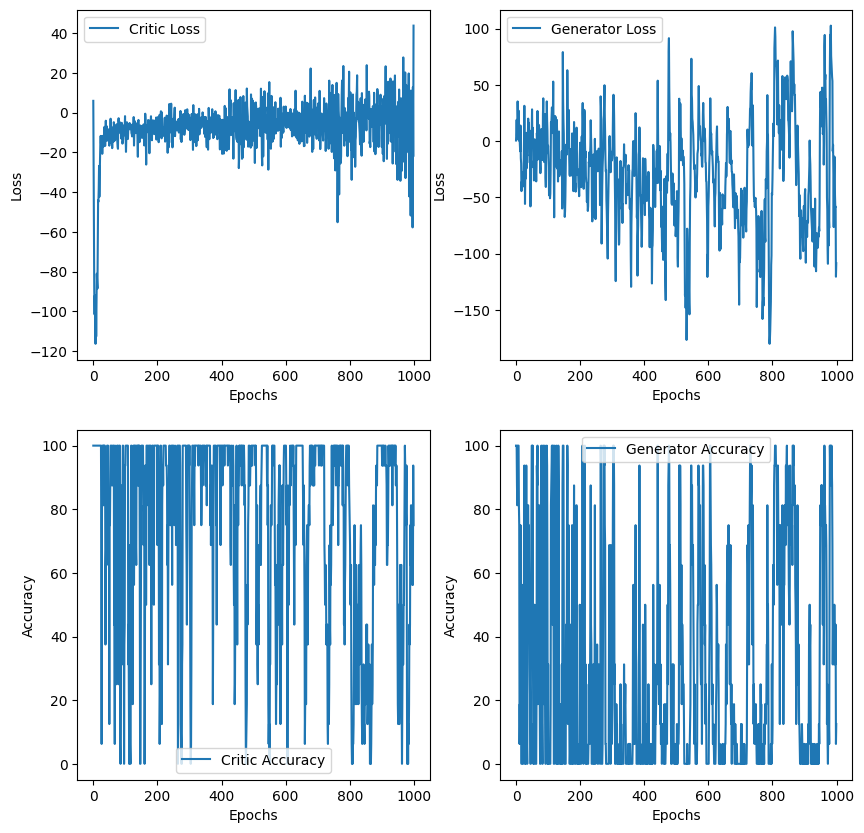

In [63]:
import matplotlib.pyplot as plt

def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()
    
    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()
    
    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()
    
    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()

plot_losses_and_accuracy(loss_history)